In [1]:
import tensorflow as tf
import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
from jax.experimental import stax
from jax.experimental.stax import (Conv, Dense, MaxPool, Relu, Flatten)
from jax import jit, grad, random,vmap,value_and_grad
import jax.nn as jnn
from jax.tree_util import tree_multimap
import math
from scipy.special import softmax
import matplotlib.pyplot as plt
import warnings
from functools import partial # for use with vmap

In [2]:
def data_parse(record):
    features = {
        'N': tf.io.FixedLenFeature([], tf.int64),
        'labels': tf.io.FixedLenFeature([16], tf.float32),
        'elements': tf.io.VarLenFeature(tf.int64),
        'coords': tf.io.VarLenFeature(tf.float32),
    }
    parsed_features = tf.io.parse_single_example(
        serialized=record, features=features)
    coords = tf.reshape(tf.sparse.to_dense(parsed_features['coords'], default_value=0),[-1,4])
    elements = tf.sparse.to_dense(parsed_features['elements'], default_value=0)
    return (elements, coords), parsed_features['labels']
data = tf.data.TFRecordDataset(
    'qm9.tfrecords', compression_type='GZIP').map(data_parse)

In [3]:
def make_graph(e,x):
    e = e.numpy()
    x = x.numpy()
    r = x[:,:3]
    r2 = np.sum((r - r[:,np.newaxis,:])**2,axis=-1)
    edges = np.where(r2!=0, 1/r2,0.0) #[N,N]
    nodes = np.zeros((len(e),9))
    nodes[np.arange(len(e)), e-1] = 1
    return nodes,edges

def get_label(y):
    return y.numpy()[13]

In [4]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    #todo: add reg
    l2=np.mean((targets - predictions)**2)
    #print('loss',l2)
    return l2

@jit
def update(i, opt_state,inputs,targets):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params,inputs,targets), opt_state)

#This is the function I wrote for GCN
def GCN(out_dim,embed_dim):
    def init_fun(rng,input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        #trainable weights
        w = np.random.normal(size = (4,embed_dim,out_dim))
        w1 = w[0]
        w2 = w[1]
        w3 = w[2]
        w4 = w[3]
        #w2 = np.random.normal(size = (4,embed_dim,out_dim))
        return output_shape, (w1,w2,w3,w4)
    
    def apply_fun(train_weights,inputs, **kwargs):
        #wq has shape (9,10), output from query has shape (5,10)
        nodes,edges = inputs

        #print('nodes and weights',nodes.shape,train_weights[0].shape)
        query = jnp.dot(nodes,train_weights[0]) 

        #pairwise distances are used here wk has shape of (9,10), output from keys has shape (5,5,10)
        keys = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[1]) * edges
        d_sq = math.sqrt(keys.shape[-1])
        b = jnn.softmax(query[jnp.newaxis,...] * keys/d_sq)

        #wv has shape (9,10), output from values has shape (5,5,10)
        values = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[2])

        messages = b * values #out shape (5,5,10)

        net_message = jnp.mean(messages,axis= 1)
        self_message = nodes @ train_weights[3]

        #self loop and graph level features
        out_nodes = jnp.mean(jnn.relu((net_message+self_message)))

        return out_nodes
    
    return init_fun,apply_fun

In [14]:
#this is what im not sure about batching data. How to batch data. You will have to figure it out.
embed_dim = 4
i = 0
embed_nodes,embed_edges,data_labels = [],[],[]
out_dim = 10
num_steps = 50
num_epochs = 5
train_loss = []
rng = random.PRNGKey(0)
 
for d in data:
    (e,x),y = d
    nodes,edges = make_graph(e,x)
    label = get_label(y)
    
    #get node embeddings instead of one-hot 
    embed_nodes.append(nodes@np.random.normal(size=(9,embed_dim)))
    #get edge embeddings from pairwise distances
    embed_edges.append(edges[...,np.newaxis] * np.random.normal(size=(1,len(edges),out_dim)))
    #labels will be as they are 
    data_labels.append(label)
    i +=1
    if i ==100:
        break
        
embed_nodes = np.asarray(embed_nodes)
embed_edges = np.asarray(embed_edges)
data_labels = np.asarray(data_labels)
print(embed_nodes.shape) 
print(embed_edges.shape) 
print(data_labels.shape) 

(100,)
(100,)
(100,)


/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [18]:


# This is serialization of the layers
net_init, net_apply = stax.serial(
    GCN(out_dim,embed_dim),
    #Dense(16), Relu,
    #Dense(1)
)


In [19]:

#Now this loop is wrong I think, We shouldn't be feeding one data point at a time right?
#I guess we have to vectorize the nodes,edges and labels rather than going
#through the data one by one?

for ep in range(num_epochs):
    for j in range(len(embed_nodes)):
        
        #Also we shouldn't have to initialize random weights for each data node
        #element_embeddings = np.random.normal(size=(9,embed_dim))
        #embed_nodes = data_nodes[i] @ element_embeddings
        #print(embed_nodes.shape)

        
        #edge_embeddings = np.random.normal(size=(1,len(data_edges[i]),out_dim))
        #embed_edges = data_edges[i][...,np.newaxis] * edge_embeddings

        out_shape, net_params =net_init(rng,embed_nodes[j].shape)
        #print(embed_nodes.shape,out_shape)

        inputs = (embed_nodes[j],embed_edges[j])
        label = data_labels[j]
        #losses = loss(net_params,inputs,label)

        opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
        opt_state = opt_init(net_params)


        for k in range(num_steps):
            opt_state = update(k, opt_state,inputs,label)
        trained_params = get_params(opt_state)
        train_loss.append(loss(trained_params,inputs,label))

    #and getting an increasing loss. Please troubleshoot. This comes from batching I think,
    # I haven't done it right


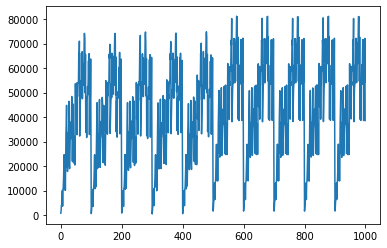

In [20]:
plt.plot(train_loss, label='Training Loss')

plt.show()

## Check this code

In [21]:
i = 0
embed_dim = 4
embed_nodes,embed_edges,data_labels = [],[],[]
out_dim = 10
num_steps = 50
num_epochs = 5
train_loss = []
rng = random.PRNGKey(0)
 
for d in data:
  
    (e,x),y = d
    nodes,edges = make_graph(e,x)
    print(nodes.shape,'nodes')
    print(edges.shape,'edges')
    label = get_label(y)
    
    #get node embeddings instead of one-hot 
    em_nodes = nodes@np.random.normal(size=(9,embed_dim))
    print(em_nodes.shape,'embedded nodes')
    embed_nodes.append(nodes@np.random.normal(size=(9,embed_dim)))
    
    #get edge embeddings from pairwise distances
    em_edges = np.random.normal(size=(len(edges),len(edges),out_dim))
    print(em_edges.shape,'embedded edges')
    embed_edges.append(edges[...,np.newaxis] * em_edges)
    #labels will be as they are 
    data_labels.append(label)
    i +=1
    if i ==1:
        break
        
embed_nodes = np.asarray(embed_nodes)
embed_edges = np.asarray(embed_edges)
data_labels = np.asarray(data_labels)
#print(embed_nodes.shape) 
#print(embed_edges.shape) 
#print(data_labels.shape) 

(5, 9) nodes
(5, 5) edges
(5, 4) embedded nodes
(5, 5, 10) embedded edges


/scratch/gwellawa/.conda/htf2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [22]:
def loss(inputs, targets,params):
    nodes,edges = inputs
    # Computes average loss for the batch
    predictions = y_hat(nodes,edges,params)
    l2=np.mean((targets - predictions)**2)
   
    return l2

@jit
def update(i, opt_state,inputs,targets):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(inputs,targets,params), opt_state)

def GCN(out_dim,embed_dim):
    def init_fun():
        #output_shape = input_shape[:-1] + (out_dim,)
        #trainable weights
        w = np.random.normal(size = (4, embed_dim,out_dim))
        w1 = w[0]
        w2 = w[1]
        w3 = w[2]
        w4 = w[3]
        #w2 = np.random.normal(size = (4,embed_dim,out_dim))
        return (w1,w2,w3,w4)
    
    def apply_fun(train_weights,inputs, **kwargs):
        #wq has shape (9,10), output from query has shape (5,10)
        nodes,edges = inputs

        #print('nodes and weights',nodes.shape,train_weights[0].shape)
        query = jnp.dot(nodes,train_weights[0]) 

        #pairwise distances are used here wk has shape of (9,10), output from keys has shape (5,5,10)
        keys = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[1]) * edges
        d_sq = math.sqrt(keys.shape[-1])
        b = jnn.softmax(query[jnp.newaxis,...] * keys/d_sq)

        #wv has shape (9,10), output from values has shape (5,5,10)
        values = jnp.dot(jnp.repeat(nodes[jnp.newaxis,...],nodes.shape[0],axis=0), train_weights[2])

        messages = b * values #out shape (5,5,10)

        net_message = jnp.mean(messages,axis= 1)
        self_message = nodes @ train_weights[3]

        #self loop
        #out_nodes = jnp.mean(jnn.relu((net_message+self_message)) )
        #todo: get mean
        out_nodes = jnn.relu((net_message+self_message))
        #print(out_nodes.shape)
        #node_avg = jnp.mean(nodes,axis=1)

        return out_nodes,edges,train_weights
    
    return init_fun,apply_fun
  

gcn_init,gcn_apply = GCN(out_dim,embed_dim)
params = gcn_init()
opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)

def y_hat(n,e,params):
    n,e,params = gcn_apply(params,(n,e))
    n,e,params = gcn_apply(params,(n,e))
    return jnp.mean(n)



#in_shape = (-1,n.shape[0])
train_loss = []
for i in range(len(embed_nodes)):
 
    
    #print(embed_nodes.shape,out_shape)
    inputs = (embed_nodes[i],embed_edges[i])
    label = data_labels[i]
    #losses = loss(net_params,inputs,label)
    opt_state = opt_init(params)

    
    for j in range(num_steps):
        opt_state = update(j, opt_state,inputs,label)
    
    trained_params = get_params(opt_state)
    train_loss.append(loss(trained_params,inputs,label))

    
print(train_loss)

TypeError: Incompatible shapes for dot: got (5, 10) and (4, 10).